In [1]:
import pandas as pd


def load_dataset(path):
    # parse the dataset
    df = pd.read_csv(path)

    ################ distilled from notebook 0 ################
    # check the integrity
    assert df.isna().any().any() == False, 'There is at least one missing value.'
    assert df['Timestamp'].is_monotonic_increasing, 'Timestamp is not sorted.'

    # type-cast
    df['abstime'] = pd.to_datetime(df['Timestamp'], unit='s').round('us')
    df['monotime'] = df['Timestamp'] - df['Timestamp'].min()
    df['aid_int'] = df['Arbitration_ID'].map(lambda x: int(x, 16))
    df['y'] = df['Class'].map({'Normal': 0, 'Attack': 1})

    ################ distilled from notebook 1 ################
    # calculate the stream-wise timedelta
    df['Timedelta'] = df.groupby('Arbitration_ID')['Timestamp'].diff()

    return df


df_stationary = load_dataset('0_Preliminary/0_Training/Pre_train_S_0.csv')
df_driving = load_dataset('0_Preliminary/0_Training/Pre_train_D_0.csv')

# Shannon index
[Wikipedia/Diversity index](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index)
> *"... a popular diversity index ... where it is also known as Shannon's diversity index."*


The equation: $H' = -\sum_{i=1}^N p_i \ln p_i$

where
- $N$ the number of types
- $p_i$ the proportion of individuals belonging to the $i$-th species



## 1. Measure the $p_i$s

In [2]:
count = df_driving['Arbitration_ID'].value_counts()
p_i = count / df_driving.shape[0]
p_i

260    0.041629
153    0.041629
220    0.041629
251    0.041623
367    0.041623
         ...   
5B0    0.000418
043    0.000418
5BE    0.000413
07F    0.000413
57F    0.000206
Name: Arbitration_ID, Length: 73, dtype: float64

## 2. Calculate $\ln{p_i}$

In [3]:
import numpy as np

np.log(p_i)

260   -3.178958
153   -3.178958
220   -3.178958
251   -3.179091
367   -3.179091
         ...   
5B0   -7.779584
043   -7.779584
5BE   -7.793007
07F   -7.793007
57F   -8.486154
Name: Arbitration_ID, Length: 73, dtype: float64

## 3. Calculate $p_i * \ln{p_i}$ for all $i\in\{1..N\}$

In [4]:
p_i * np.log(p_i)

260   -0.132337
153   -0.132337
220   -0.132337
251   -0.132325
367   -0.132325
         ...   
5B0   -0.003253
043   -0.003253
5BE   -0.003215
07F   -0.003215
57F   -0.001751
Name: Arbitration_ID, Length: 73, dtype: float64

## 4. Get $H$

In [5]:
H = - (p_i * np.log(p_i)).sum()
print('The deversity index for the entire dataset is...', H)

The deversity index for the entire dataset is... 3.7056849451933016


In [6]:
def get_H(series_aid):
    count = series_aid.value_counts()
    p_i = count / series_aid.shape[0]
    return - (p_i * np.log(p_i)).sum()


get_H(df_stationary['Arbitration_ID']), get_H(df_driving['Arbitration_ID']),

(3.703013094908975, 3.7056849451933016)

In [7]:
get_H(df_stationary.loc[:2000, 'Arbitration_ID']), get_H(df_stationary.loc[10000:20000, 'Arbitration_ID'])

(3.6976371388430116, 3.703190755903826)

In [8]:
for path in (
        '0_Preliminary/0_Training/Pre_train_S_0.csv',
        '0_Preliminary/0_Training/Pre_train_S_1.csv',
        '0_Preliminary/0_Training/Pre_train_S_2.csv',
        '0_Preliminary/0_Training/Pre_train_D_0.csv',
        '0_Preliminary/0_Training/Pre_train_D_1.csv',
        '0_Preliminary/0_Training/Pre_train_D_2.csv',
):
    print(path, get_H(load_dataset(path)['Arbitration_ID']))

0_Preliminary/0_Training/Pre_train_S_0.csv 3.703013094908975
0_Preliminary/0_Training/Pre_train_S_1.csv 3.766636844524696
0_Preliminary/0_Training/Pre_train_S_2.csv 3.771987865577981
0_Preliminary/0_Training/Pre_train_D_0.csv 3.7056849451933016
0_Preliminary/0_Training/Pre_train_D_1.csv 3.769784213704188
0_Preliminary/0_Training/Pre_train_D_2.csv 3.771394391395099


# Sliding window concept

With Pandas rolling window calculations, we can easily get an $H$ of each window


<img src="https://i.dailymail.co.uk/i/pix/2016/02/18/09/31565AFF00000578-3452451-image-m-17_1455786348641.jpg"><img src="https://i.dailymail.co.uk/i/pix/2016/02/18/09/31565B0C00000578-3452451-image-a-15_1455786335295.jpg">

## Calculate $H$ for each window

window size is 2402 (average number of messages per sec), calculate evey 10 messages.
These values are parameters of the IDS. So you may change the value.

In [9]:
df_driving['entropy'] = df_driving.rolling(window=2402, min_periods=2402, step=10)['aid_int'].apply(get_H)
df_driving['entropy'] = df_driving['entropy'].ffill()

<AxesSubplot: xlabel='monotime'>

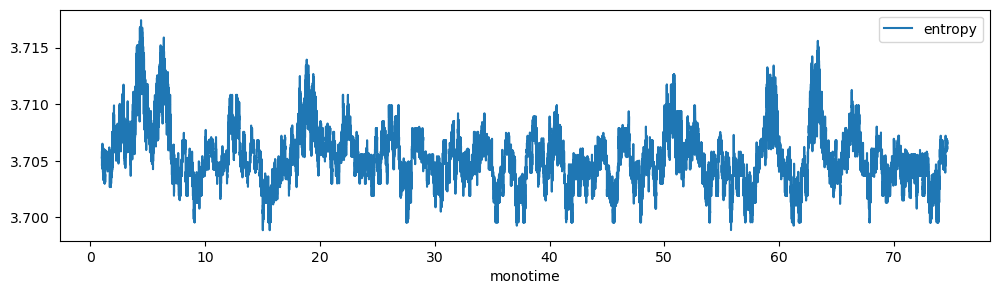

In [10]:
df_driving.plot(x='monotime', y='entropy', figsize=(12, 3))

## Analyze an intrusion dataset

In [11]:
df_intrusion = load_dataset('0_Preliminary/0_Training/Pre_train_D_1.csv')
df_intrusion['entropy'] = df_intrusion.rolling(window=2402, min_periods=2402, step=10)['aid_int'].apply(get_H)
df_intrusion['entropy'] = df_intrusion['entropy'].ffill()

<AxesSubplot: xlabel='monotime'>

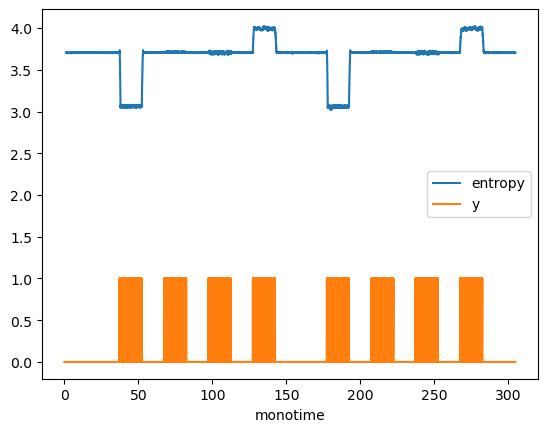

In [12]:
df_intrusion.plot(x='monotime', y=['entropy', 'y'])

<AxesSubplot: xlabel='monotime'>

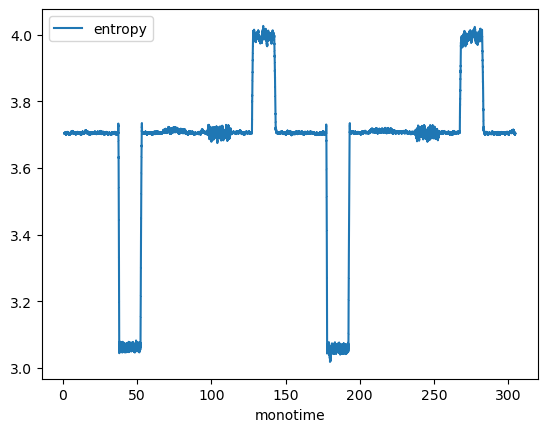

In [13]:
df_intrusion.plot(x='monotime', y='entropy')

# Intrusion detection

if an $H$ does not satisfy $3.69 \leq H \leq 3.72$, then we consider there was an intrusion.

In [14]:
df_intrusion['y_predicted'] = 0
rowidx = ~df_intrusion['entropy'].between(3.69, 3.72)
df_intrusion.loc[rowidx, 'y_predicted'] = 1

# Evaluation

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

abstime_ceil = df_intrusion['abstime'].dt.ceil('10ms')
y = df_intrusion.groupby(abstime_ceil)['y'].max()
y_predicted = df_intrusion.groupby(abstime_ceil)['y_predicted'].max()

print(confusion_matrix(y, y_predicted))
print(classification_report(y, y_predicted))

[[20003   548]
 [ 3520  6416]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     20551
           1       0.92      0.65      0.76      9936

    accuracy                           0.87     30487
   macro avg       0.89      0.81      0.83     30487
weighted avg       0.87      0.87      0.86     30487



F1 score of the label `attack` is 
Are there any possible improvements? such as window size, threshold, ...